# Assignment Module 2: Product Classification

The goal of this assignment is to implement a neural network that classifies smartphone pictures of products found in grocery stores. The assignment will be divided into two parts: first, you will be asked to implement from scratch your own neural network for image classification; then, you will fine-tune a pretrained network provided by PyTorch.


## Preliminaries: the dataset

The dataset you will be using contains natural images of products taken with a smartphone camera in different grocery stores:

<p align="center">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Granny-Smith.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Pink-Lady.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Lemon.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Banana.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Vine-Tomato.jpg" width="150">
</p>
<p align="center">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Yellow-Onion.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Green-Bell-Pepper.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Arla-Standard-Milk.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Oatly-Natural-Oatghurt.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Alpro-Fresh-Soy-Milk.jpg" width="150">
</p>

The products belong to the following 43 classes:
```
0.  Apple
1.  Avocado
2.  Banana
3.  Kiwi
4.  Lemon
5.  Lime
6.  Mango
7.  Melon
8.  Nectarine
9.  Orange
10. Papaya
11. Passion-Fruit
12. Peach
13. Pear
14. Pineapple
15. Plum
16. Pomegranate
17. Red-Grapefruit
18. Satsumas
19. Juice
20. Milk
21. Oatghurt
22. Oat-Milk
23. Sour-Cream
24. Sour-Milk
25. Soyghurt
26. Soy-Milk
27. Yoghurt
28. Asparagus
29. Aubergine
30. Cabbage
31. Carrots
32. Cucumber
33. Garlic
34. Ginger
35. Leek
36. Mushroom
37. Onion
38. Pepper
39. Potato
40. Red-Beet
41. Tomato
42. Zucchini
```

The dataset is split into training (`train`), validation (`val`), and test (`test`) set.

The following code cells download the dataset and define a `torch.utils.data.Dataset` class to access it. This `Dataset` class will be the starting point of your assignment: use it in your own code and build everything else around it.

In [1]:
try:
    import google.colab
    !git clone https://github.com/marcusklasson/GroceryStoreDataset.git
except: pass

In [2]:
from pathlib import Path
from PIL import Image
from torch import Tensor
from torch.utils.data import Dataset
from typing import List, Tuple

In [3]:
class GroceryStoreDataset(Dataset):

    def __init__(self, split: str, transform=None) -> None:
        super().__init__()

        self.root = Path("GroceryStoreDataset/dataset")
        self.split = split
        self.paths, self.labels = self.read_file()

        self.transform = transform

    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, idx) -> Tuple[Tensor, int]:
        img = Image.open(self.root / self.paths[idx])
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

    def read_file(self) -> Tuple[List[str], List[int]]:
        paths = []
        labels = []

        with open(self.root / f"{self.split}.txt") as f:
            for line in f:
                # path, fine-grained class, coarse-grained class
                path, _, label = line.replace("\n", "").split(", ")
                paths.append(path), labels.append(int(label))

        return paths, labels

    def get_num_classes(self) -> int:
        return max(self.labels) + 1

## Part 1: design your own network

Your goal is to implement a convolutional neural network for image classification and train it on `GroceryStoreDataset`. You should consider yourselves satisfied once you obtain a classification accuracy on the **validation** split of **around 60%**. You are free to achieve that however you want, except for a few rules you must follow:

- You **cannot** simply instantiate an off-the-self PyTorch network. Instead, you must construct your network as a composition of existing PyTorch layers. In more concrete terms, you can use e.g. `torch.nn.Linear`, but you **cannot** use e.g. `torchvision.models.alexnet`.

- Justify every *design choice* you make. Design choices include network architecture, training hyperparameters, and, possibly, dataset preprocessing steps. You can either (i) start from the simplest convolutional network you can think of and add complexity one step at a time, while showing how each step gets you closer to the target ~60%, or (ii) start from a model that is already able to achieve the desired accuracy and show how, by removing some of its components, its performance drops (i.e. an *ablation study*). You can *show* your results/improvements however you want: training plots, console-printed values or tables, or whatever else your heart desires: the clearer, the better.

Don't be too concerned with your network performance: the ~60% is just to give you an idea of when to stop. Keep in mind that a thoroughly justified model with lower accuracy will be rewarded **more** points than a poorly experimentally validated model with higher accuracy.

### Imports

In [4]:
! python3.11 -m pip install --upgrade pip
! pip install -q wandb
! pip install -q torchmetrics
! pip install torchsummary

/Users/pelle/.zshenv:.:6: no such file or directory: /usr/local/env
DEPRECATION: Loading egg at /usr/local/lib/python3.11/site-packages/jupyter-1.0.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
/Users/pelle/.zshenv:.:6: no such file or directory: /usr/local/env
DEPRECATION: Loading egg at /usr/local/lib/python3.11/site-packages/jupyter-1.0.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
/Users/pelle/.zshenv:.:6: no such file or directory: /usr/local/env
DEPRECATION: Loading egg at /usr/local/lib/python3.11/site-packages/jupyter-1.0.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion c

### Weights and Biases for following the net

In [5]:
import wandb

WANDB_USER = "lollopelle-2-universit-di-bologna"
WANDB_PROJECT = "IPCV-assignment-2"

### Imports

In [6]:
# Standard library imports
import csv
import copy
import random
from pathlib import Path
from typing import Any, Dict
import os
import json
from datetime import datetime
import time

# Third-party library imports
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from tqdm.notebook import tqdm

# PyTorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR, LambdaLR
from torch.utils.data import DataLoader
import torch.utils
from torchmetrics.classification.accuracy import Accuracy
from torchsummary import summary

# Torchvision imports
from torchvision import transforms as T
from torchvision.models import resnet18, ResNet18_Weights

#### Functions

In [7]:
def fix_random(seed: int) -> None:
    """Fix all the possible sources of randomness.

    Args:
        seed: the seed to use.
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

def extract_classes(csv_file_path: str) -> dict:
    """
    Extract unique pairs of IDs and labels from a CSV file.

    This function reads a CSV file, extracts the third and fourth columns,
    and creates a dictionary with unique pairs of IDs (from the fourth column)
    and labels (from the third column).

    Parameters:
    csv_file_path (str): The path to the CSV file.

    Returns:
    dict: A dictionary with IDs as keys and labels as values.
    """

    # Dictionary to store the unique pairs
    classes = {}

    # Read the CSV file
    with open(csv_file_path, mode='r', newline='', encoding='utf-8') as file:
        csv_reader = csv.reader(file)

        # Skip the CSV header
        next(csv_reader)

        for row in csv_reader:
            label = row[2]       # Third column
            id = int(row[3])     # Fourth column

            # Add the pair to the dictionary if it doesn't already exist
            if id not in classes:
                classes[id] = label

    return classes

def show_grid(dataset: GroceryStoreDataset, classes: dict) -> None:
    """Shows a grid with random images taken from the dataset.

    Args:
        dataset: the dataset containing the images.
        process: a function to apply on the images before showing them.
    """
    fig = plt.figure(figsize=(15, 5))
    indices_random = np.random.randint(10, size=10, high=len(classes.keys()))

    for count, idx in enumerate(indices_random):
        fig.add_subplot(2, 5, count + 1)
        item = dataset.__getitem__(idx) # (Tensor, idx)
        title = classes[item[1]]
        plt.title(title)
        image_processed = item[0]
        plt.imshow(T.ToPILImage()(image_processed))
        plt.axis("off")

    plt.tight_layout()
    plt.show()

def parse_compose(v):
  res = []
  for t in str(v).split("\n")[1:]:
    res.append(t.strip("    "))
  return res[:-1]

### Configuration

In [8]:
fix_random(seed=42)

device = "cpu"
if torch.cuda.is_available():
  print("All good, a GPU is available")
  device = torch.device("cuda:0")
else:
  print("Please set GPU via Edit -> Notebook Settings")

cfg = {
    "resize_size": 256,
    "crop_size": 224,
    "batch_size": 16,
    "num_epochs": 50,
    "lr": 1e-3,
    "wd": 5e-4,
    "step_size": 5
}

Please set GPU via Edit -> Notebook Settings


### Data

In [9]:
# In  order to convert integer classes into their literal
classes = extract_classes(csv_file_path = 'GroceryStoreDataset/dataset/classes.csv')

# Preprocessing
mean_image_net = [0.485, 0.456, 0.406]                              
std_image_net = [0.229, 0.224, 0.225]   
       
cfg["augment"] = True   # True/False                     
data_transforms = {
    "train": T.Compose([
                        T.RandomResizedCrop(cfg["crop_size"]),
                        T.RandomHorizontalFlip(),
                        T.RandomVerticalFlip(),                
                        T.RandomRotation(180),                              # rotation in all directions
                        T.RandomAffine(degrees=0, translate=(0.1, 0.1)),    # translations of 10%
                        T.RandomPerspective(distortion_scale=0.1, p=0.5),       
                        T.ToTensor(),
                        T.Normalize(mean_image_net, std_image_net)
                    ]),

    "val": T.Compose([
                        T.Resize(cfg["resize_size"]),               
                        T.CenterCrop(cfg["crop_size"]),             
                        T.ToTensor(),                               
                        T.Normalize(mean_image_net, std_image_net)  
                    ]),

    "test": T.Compose([
                        T.Resize(cfg["resize_size"]),               
                        T.ToTensor()                        
                    ]) # TODO: cut, it's just for debug
}

# Datasets
data_train = GroceryStoreDataset(split="train", transform=data_transforms["train"] if cfg["augment"] else None)
data_val = GroceryStoreDataset(split="val", transform=data_transforms["val"])
data_test = GroceryStoreDataset(split="test", transform=data_transforms["test"])

# DEBUG
# show_grid(dataset=data_train, classes=classes)
# show_grid(dataset=data_test, classes=classes)
# show_grid(dataset=data_val, classes=classes)

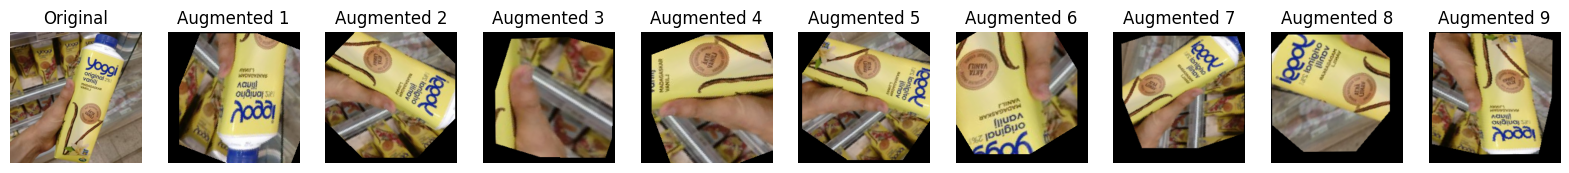

In [10]:
# TODO: delete cell, its just to visualize transformations

inv_normalize = T.Compose([
    T.Normalize(mean=[-m / s for m, s in zip(mean_image_net, std_image_net)],
                std=[1 / s for s in std_image_net])
])

# Load and prepare the image
img = Image.open("./GroceryStoreDataset/dataset/train/Packages/Yoghurt/Yoggi-Vanilla-Yoghurt/Yoggi-Vanilla-Yoghurt_020.jpg").convert("RGB")

# Apply transformations directly to the PIL image
n=9
transformed_images = [data_transforms["train"](img) for _ in range(n)]

# Convert tensors back to PIL images for visualization
# Unnormalize and convert to PIL
transformed_images_pil = [T.ToPILImage()(inv_normalize(img_tensor)) for img_tensor in transformed_images]

# Display the images
fig, axes = plt.subplots(1, n+1, figsize=(20, 5))
axes[0].imshow(img)
axes[0].set_title('Original')
axes[0].axis('off')

# for i, pil_img in enumerate(transformed_images_pil):
for i, pil_img in enumerate(transformed_images_pil):
    axes[i + 1].imshow(pil_img)
    axes[i + 1].set_title(f'Augmented {i + 1}')
    axes[i + 1].axis('off')

plt.show()

### Models

We can start with the simplest CNN we have seen, like the Vanilla, in order to have a starting idea of performances and a starting model to put hands on.

In [11]:
class ProjectCNN_v1(nn.Module):
    def __init__(self, n_classes):
        super(ProjectCNN_v1, self).__init__()
        
        ## Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)  # 32 filters for simpler details
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1) # 64 filters for more complex details
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)    # reduces spatial dimensions, decreases computational load, improves  
                                                                        # translation invariance, highlights prominent features, and helps 
                                                                        # prevent overfitting.
        
        ## FC layers
        self.fc1 = nn.Linear(64 * 56 * 56, 128) # combines features in representations
        self.fc2 = nn.Linear(128, n_classes)    # from representations to logits 

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 32 x 112 x 112
        x = self.pool(F.relu(self.conv2(x)))  # 64 x 56 x 56
        x = x.view(x.size(0), -1) # to feed the FCs       
        x = F.relu(self.fc1(x))               
        x = self.fc2(x)                       
        return x

In order to learn more complex and hierarchical features from the input images, by capturing finer details and more abstract patterns, we need to **increase the depth**, adding more convolutional layers. Moreover the layers must have a higher and higher number of filters, since this expansion helps in capturing a wider range of features at different levels of abstraction. This must be followed by an incremental use of pooling in order to manage computational complexity and keep the feature maps at a manageable size for the fully connected layers.

In [27]:
class ProjectCNN_v2(nn.Module):
    def __init__(self, n_classes):
        super(ProjectCNN_v2, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        # FC layers
        self.fc1 = nn.Linear(512 * 7 * 7, 1024) 
        self.fc2 = nn.Linear(1024, 512) # Further refines the representation
        self.fc3 = nn.Linear(512, n_classes)    

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 32 x 112 x 112
        x = self.pool(F.relu(self.conv2(x)))  # 64 x 56 x 56
        x = self.pool(F.relu(self.conv3(x)))  # 128 x 28 x 28
        x = self.pool(F.relu(self.conv4(x)))  # 256 x 14 x 14
        x = self.pool(F.relu(self.conv5(x)))  # 512 x 7 x 7
        x = x.view(x.size(0), -1)             
        x = F.relu(self.fc1(x))               
        x = F.relu(self.fc2(x))               
        x = self.fc3(x)                       
        return x

In order to increase even more the depth and improve the training, we introduce **residual blocks** which helps by mitigating the vanishing gradient problem and allowing gradients to flow more effectively through the network.
We change each convolutional layer with a residual block.

In [13]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.relu = nn.ReLU(inplace=True) 
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        
        # Shortcut connection (skip connection) to add the input to the output of convolutions
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            # If the dimensions change, adjust the shortcut path, in order to maintain consistency in the feature maps
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, padding=0) # 1x1 convolution to match dimensions
            )
    
    def forward(self, x):
        out = self.relu(self.conv1(x))
        out = self.conv2(out)
        out += self.shortcut(x)
        out = self.relu(out)
        return out

class ProjectCNN_v3(nn.Module):
    def __init__(self, n_classes):
        super(ProjectCNN_v3, self).__init__()
        
        # Residual blocks
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),  
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  
        )
        self.layer2 = nn.Sequential(
            ResidualBlock(32, 64),  
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  
        )
        self.layer3 = nn.Sequential(
            ResidualBlock(64, 128),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        )
        self.layer4 = nn.Sequential(
            ResidualBlock(128, 256),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        )
        self.layer5 = nn.Sequential(
            ResidualBlock(256, 512),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        )
        
        # FC layers
        self.fc1 = nn.Linear(512 * 7 * 7, 1024)  
        self.fc2 = nn.Linear(1024, 512)  
        self.fc3 = nn.Linear(512, n_classes)  
    
    def forward(self, x):
        x = self.layer1(x)  
        x = self.layer2(x)  
        x = self.layer3(x)  
        x = self.layer4(x)  
        x = self.layer5(x)  
        x = x.view(x.size(0), -1)  
        x = F.relu(self.fc1(x))  
        x = F.relu(self.fc2(x))  
        x = self.fc3(x)  
        return x


We introduce Batch Normalization, that stabilizes and accelerates training in deeper networks.

In [24]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels) # here
        self.relu = nn.ReLU(inplace=True)  
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels) # here
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, padding=0),  
                nn.BatchNorm2d(out_channels)    # here
            )
    
    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = self.relu(out)
        return out

class ProjectCNN_v4(nn.Module):
    def __init__(self, n_classes):
        super(ProjectCNN_v4, self).__init__()
        
        # First layer
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0) 
        )
        
        # Residual blocks
        self.layer2 = nn.Sequential(
            ResidualBlock(32, 64), 
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0) 
        )
        self.layer3 = nn.Sequential(
            ResidualBlock(64, 128), 
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        )
        self.layer4 = nn.Sequential(
            ResidualBlock(128, 256), 
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        )
        self.layer5 = nn.Sequential(
            ResidualBlock(256, 512), 
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        )
        
        # FC layers
        self.fcs = nn.Sequential(
            nn.Linear(512 * 7 * 7, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, n_classes)
        )
        # self.fc1 = nn.Linear(512 * 7 * 7, 1024)  
        # self.fc2 = nn.Linear(1024, 512)  
        # self.fc3 = nn.Linear(512, n_classes)  
    
    def forward(self, x):
        x = self.layer1(x)  
        x = self.layer2(x)  
        x = self.layer3(x)  
        x = self.layer4(x)  
        x = self.layer5(x)  
        x = x.view(x.size(0), -1)  
        # x = F.relu(self.fc1(x))  
        # x = F.relu(self.fc2(x))  
        # x = self.fc3(x)  
        x = self.fcs(x)
        return x

In [28]:
cfg["model"] = "v2"
match cfg["model"] :
    case "v1" : model = ProjectCNN_v1(n_classes=len(classes))
    case "v2" : model = ProjectCNN_v2(n_classes=len(classes))
    case "v3" : model = ProjectCNN_v3(n_classes=len(classes))
    case "v4" : model = ProjectCNN_v4(n_classes=len(classes))
    case _ : raise NameError("Unknown model in FLAG")

# Verifies if the model is already on the device
if next(model.parameters()).device != device:
    model.to(device)

In [29]:
summary(
    model,
    input_size=(3, cfg["crop_size"], cfg["crop_size"])
)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
         MaxPool2d-2         [-1, 32, 112, 112]               0
            Conv2d-3         [-1, 64, 112, 112]          18,496
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5          [-1, 128, 56, 56]          73,856
         MaxPool2d-6          [-1, 128, 28, 28]               0
            Conv2d-7          [-1, 256, 28, 28]         295,168
         MaxPool2d-8          [-1, 256, 14, 14]               0
            Conv2d-9          [-1, 512, 14, 14]       1,180,160
        MaxPool2d-10            [-1, 512, 7, 7]               0
           Linear-11                 [-1, 1024]      25,691,136
           Linear-12                  [-1, 512]         524,800
           Linear-13                   [-1, 43]          22,059
Total params: 27,806,571
Trainable para

### Trainer

In [34]:
# For automating batching

loader_train = DataLoader(
    data_train,
    batch_size=cfg["batch_size"],
    shuffle=True,
    pin_memory=True
)
loader_val = DataLoader(
    data_val,
    batch_size=cfg["batch_size"],
    shuffle=False
)
loader_test = DataLoader(
    data_test,
    batch_size=cfg["batch_size"],
    shuffle=False
)

In [35]:
class Trainer:
    def __init__(self,
            model: nn.Module,
            train_loader: DataLoader,
            val_loader: DataLoader,
            test_loader: DataLoader,
            device: torch.device,
            num_classes: int
        ) -> None:
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.device = device
        self.num_classes = num_classes
        self.num_epochs = cfg["num_epochs"]

        self.model = model.to(device)
        self.optimizer = AdamW(self.model.parameters(), lr=cfg["lr"], weight_decay=cfg["wd"])
        num_steps = self.num_epochs * len(train_loader)
        if cfg["scheduled"]:
            self.scheduler = OneCycleLR(self.optimizer, cfg["lr"], total_steps=num_steps)
        else:
            self.scheduler = LambdaLR(self.optimizer, lr_lambda=lambda epoch: 1.0)

        self.step = 0
        self.best_acc = 0.0

        wandb.init(name=cfg["run_name"], entity=WANDB_USER, project=WANDB_PROJECT, config=cfg)
        self.ckpt_path = Path("ckpts")
        self.ckpt_path.mkdir(exist_ok=True)

    def logfn(self, values: Dict[str, Any]) -> None:
        wandb.log(values, step=self.step, commit=False)

    def train(self) -> None:
        self.training_time = time.time()
        for _ in tqdm(range(self.num_epochs), desc="Epoch"):
            self.model.train()

            for imgs, labels in self.train_loader:
                imgs = imgs.to(self.device)
                labels = labels.to(self.device)

                pred = self.model(imgs)
                # print(pred.shape, labels.shape)
                loss = F.cross_entropy(pred, labels)

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                self.scheduler.step()

                if self.step % 10 == 0:
                    self.logfn({"train/loss": loss.item()})
                    self.logfn({"train/lr": self.scheduler.get_last_lr()[0]})

                self.step += 1

            self.eval("train")
            self.eval("val")

        wandb.finish()
        self.training_time = time.time() - self.training_time


    # def test(self) -> None:
    #     wandb.init(name=cfg["run_name"]+"_test", entity=WANDB_USER, project=WANDB_PROJECT, config=cfg)
    #     self.eval("test")
    #     wandb.finish()

    @torch.no_grad()
    def eval(self, split: str) -> None:
        self.model.eval()

        if split == "train":
            loader = self.train_loader
        elif split == "val":
            loader = self.val_loader
        # elif split == "test":
        #     loader = self.test_loader
        else:
            raise ValueError(f"Unknown split: {split}")

        acc = Accuracy("multiclass", num_classes=self.num_classes).to(self.device)

        losses = []
        for imgs, labels in loader:
            imgs = imgs.to(self.device)
            labels = labels.to(self.device)

            pred = self.model(imgs)
            loss = F.cross_entropy(pred, labels)
            losses.append(loss.item())

            pred_softmax = F.softmax(pred, dim=-1)
            acc(pred_softmax, labels)

        loss = sum(losses) / len(losses)
        accuracy = acc.compute()

        self.logfn({f"{split}/loss": loss})
        self.logfn({f"{split}/acc": accuracy})

        if accuracy > self.best_acc and split == "val":
            self.best_acc = accuracy
            torch.save(self.model.state_dict(), self.ckpt_path / f"{wandb.run.name}.pt")
            self.best_model = copy.deepcopy(self.model)

    def save_model_params(self, cfg, data_transforms):
        model_dir = os.path.join("params", f"{cfg['model']}_model")
        os.makedirs(model_dir, exist_ok=True)

        timestamp = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")  # in order not to have duplicates
        training_time_formatted = time.strftime('%H-%M-%S', time.gmtime(self.training_time))
        file_name = f"ACC={self.best_acc:.2f}____TT={training_time_formatted}____TM={timestamp}.json"
        file_path = os.path.join(model_dir, file_name)

        combined_params = {
            "cfg": cfg,
            "data_transforms": {k: parse_compose(v) for k,v in data_transforms.items()},
            "model_structure" : parse_compose(model)
        }

        with open(file_path, 'w') as f:
            json.dump(combined_params, f, indent=4)

In [ ]:
cfg["scheduled"]=True 
cfg["run_name"] = f"test: {cfg['model']}" + ("_scheduledLR" if cfg["scheduled"] else "") + ("_augmented" if cfg["augment"] else "")

# Wandb key: 3f0834114b4b33656e70323616fa377c30c83542

trainer = Trainer(
    model,
    loader_train,
    loader_val,
    loader_test,
    device,
    num_classes=len(classes.keys())
)

In [ ]:
trainer.train()

In [ ]:
print(f"Best val acc = {trainer.best_acc:.3f}")

In [ ]:
# Log results
trainer.save_model_params(cfg, data_transforms)

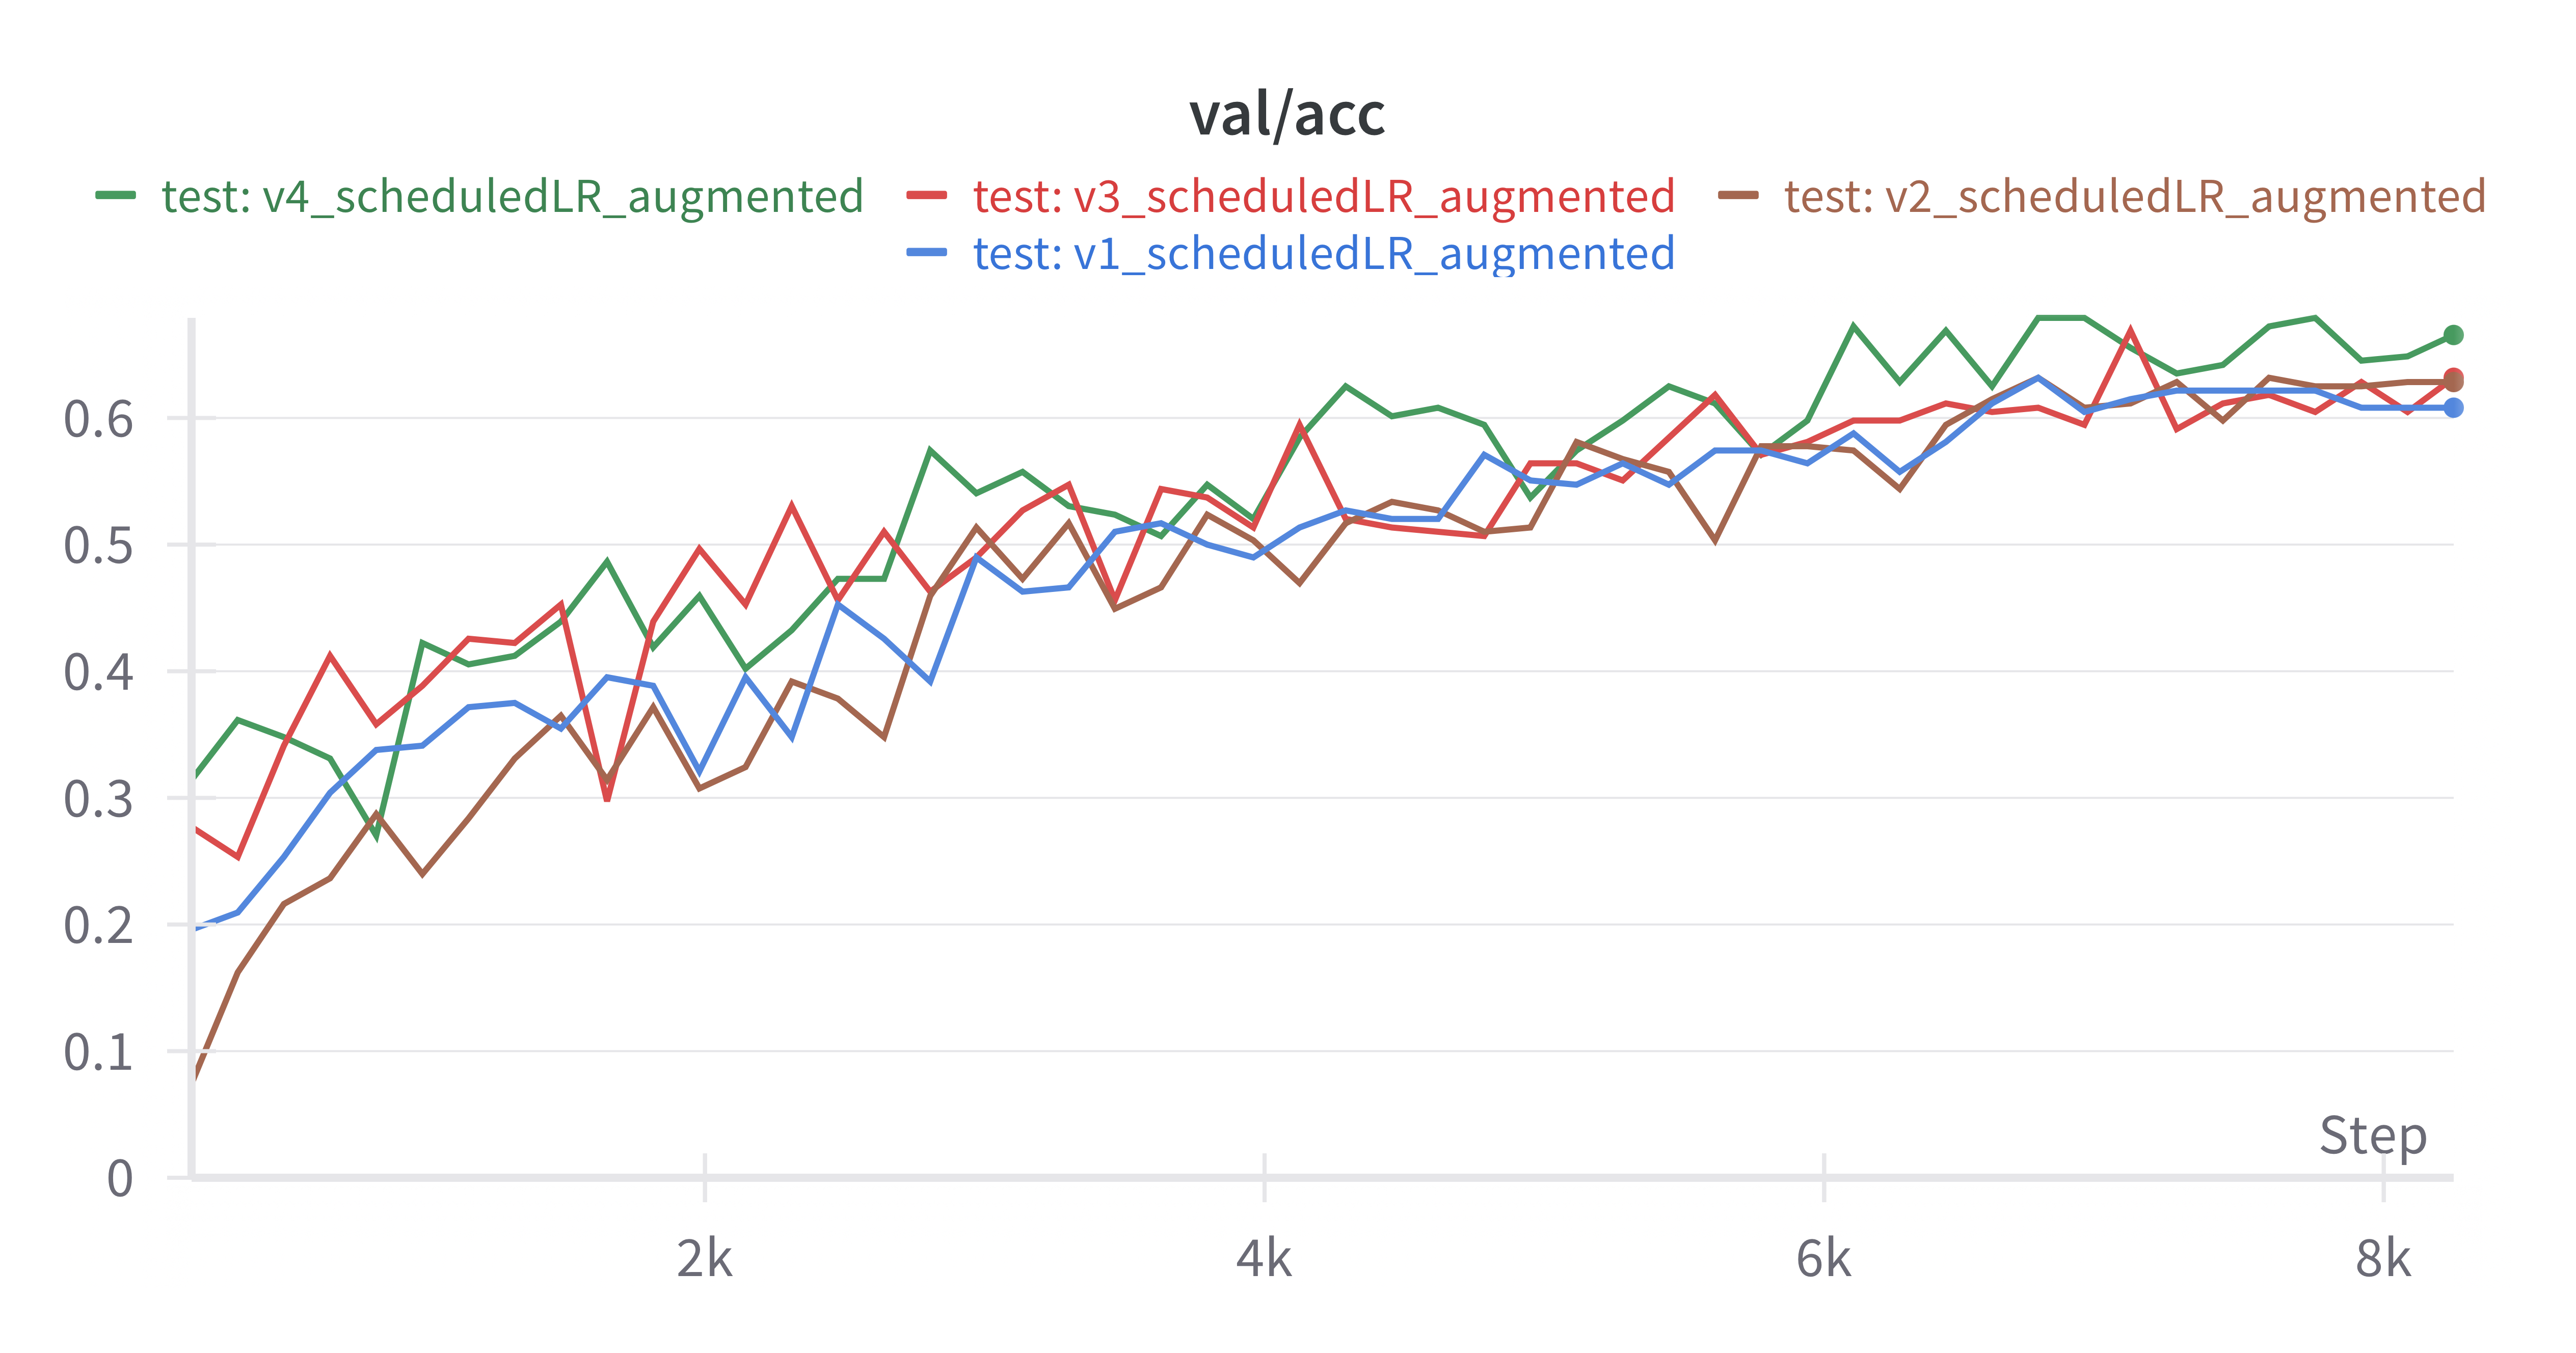

## Part 2: fine-tune an existing network

Your goal is to fine-tune a pretrained **ResNet-18** model on `GroceryStoreDataset`. Use the implementation provided by PyTorch, do not implement it yourselves! (i.e. exactly what you **could not** do in the first part of the assignment). Specifically, you must use the PyTorch ResNet-18 model pretrained on ImageNet-1K (V1). Divide your fine-tuning into two parts:

1. First, fine-tune the Resnet-18 with the same training hyperparameters you used for your best model in the first part of the assignment.
1. Then, tweak the training hyperparameters in order to increase the accuracy on the validation split of `GroceryStoreDataset`. Justify your choices by analyzing the training plots and/or citing sources that guided you in your decisions (papers, blog posts, YouTube videos, or whatever else you find enlightening). You should consider yourselves satisfied once you obtain a classification accuracy on the **validation** split **between 80 and 90%**.

### 1) Fine-tune the Resnet-18 with the same training hyperparameters you used for your best model in the first part of the assignment.

In [ ]:
# Pretrained ResNet-18 on ImageNet-1K (V1)
pt_resnet18 = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 171MB/s]


In [ ]:
## Freeze the pre-trained layers ##
for param in pt_resnet18.parameters():
    param.requires_grad = False

## Modify the last layer ##
pt_resnet18.fc = torch.nn.Linear(pt_resnet18.fc.in_features, len(classes.keys()))

## First train
cfg["run_name"] = "ResNet-18_pretrained_scratch-training"
## cfg["num_epochs"] = 5
trainer = Trainer(
    pt_resnet18,
    loader_train,
    loader_val,
    loader_test,
    device,
    num_classes=len(classes.keys())
)
trainer.train()

wandb: Currently logged in as: lollopelle-2 (lollopelle-2-universit-di-bologna). Use `wandb login --relogin` to force relogin


Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

train/acc,▁▂▄▅▆▇▇▇▇█████████████████████
train/loss,█▇▇▅▅▄▄▃▄▂▃▂▂▃▂▂▁▂▂▂▂▂▂▁▁▁▁▁▂▂▁▂▂▁▁▁▁▁▁▁
train/lr,▁▁▂▂▃▄▅▆▇▇███████▇▇▇▇▆▆▆▅▅▄▄▄▃▃▃▂▂▂▁▁▁▁▁
val/acc,▁▂▄▅▆▇▇▇▇▇▇▇██████████▇███████
val/loss,█▇▅▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/acc,0.95795
train/loss,0.1887
train/lr,0.0
val/acc,0.80743
val/loss,0.57449


In [ ]:
print(f"Best val acc (intermediate) = {trainer.best_acc:.3f}")

Best val acc (intermediate) = 0.834


In [ ]:
## Load the state of the best accuracy
sd = torch.load(f"ckpts/{cfg['run_name']}.pt")
pt_resnet18.load_state_dict(sd)

## Activate learning
for param in pt_resnet18.parameters():
    param.requires_grad = True

## Fine tuning
cfg["run_name"] = "ResNet-18_pretrained_fine-tuning"
cfg["lr"] *= 0.1
cfg["num_epochs"] = 10
trainer = Trainer(
    pt_resnet18,
    loader_train,
    loader_val,
    loader_test,
    device,
    num_classes=len(classes.keys())
)
trainer.train()

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

train/acc,▂▃▁▅▆▆█▇██
train/loss,▄▃▃▆▄█▂▃▂▄▄▅▃▅▃▃▁▂▂▄▄▂▄▃▄▃▃▂▂▂▇▁▁▁▁▄▂▂▁▃
train/lr,▁▁▂▂▃▄▅▆▆▇███████▇▇▇▇▆▆▆▅▅▄▄▄▃▃▃▂▂▂▁▁▁▁▁
val/acc,▃▃▅▁▅▄▅█▇█
val/loss,▆▇▅█▄▃▂▁▂▁
train/acc,0.98788
train/loss,0.04966
train/lr,0.0
val/acc,0.88851
val/loss,0.32398


In [ ]:
print(f"Best val acc (final) = {trainer.best_acc:.3f}")

Best val acc (final) = 0.895


### 2) Tweak the training hyperparameters in order to increase the accuracy on the validation split of `GroceryStoreDataset`.

In [ ]:
# You need to do the same but with different cfg
cfg_fine_tuning = {
    "resize_size": 256,
    "crop_size": 224,
    "batch_size": 16,
    "num_epochs": 30,
    "lr": 1e-3,
    "wd": 5e-4,
    "step_size": 5
}
cfg = cfg_fine_tuning

In [ ]:
## Freeze the pre-trained layers ##
for param in pt_resnet18.parameters():
    param.requires_grad = False

## Modify the last layer ##
pt_resnet18.fc = torch.nn.Linear(pt_resnet18.fc.in_features, len(classes.keys()))

# First train
cfg["run_name"] = "ResNet-18_pretrained_scratch-training_2"
# cfg["num_epochs"] = 5
trainer = Trainer(
    pt_resnet18,
    loader_train,
    loader_val,
    loader_test,
    device,
    num_classes=len(classes.keys())
)
trainer.train()
print(f"Best val acc (intermediate) = {trainer.best_acc:.3f}")

Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

train/acc,▁▄▇███████████████████████████
train/loss,█▇▆▄▂▂▁▂▂▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/lr,▁▁▂▂▃▄▅▆▇▇███████▇▇▇▇▆▆▆▅▅▄▄▄▃▃▃▂▂▂▁▁▁▁▁
val/acc,▁▃▆▇██████████▇████▇███▇██████
val/loss,█▆▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/acc,0.98939
train/loss,0.04075
train/lr,0.0
val/acc,0.87838
val/loss,0.33307


Best val acc (intermediate) = 0.902


In [ ]:
# Load the state of the best accuracy
sd = torch.load(f"ckpts/{cfg['run_name']}.pt")
pt_resnet18.load_state_dict(sd)

## Activate learning
for param in pt_resnet18.parameters():
    param.requires_grad = True

# Fine tuning
cfg["run_name"] = "ResNet-18_pretrained_fine-tuning_2"
cfg["lr"] *= 0.1
cfg["num_epochs"] = 10
trainer = Trainer(
    pt_resnet18,
    loader_train,
    loader_val,
    loader_test,
    device,
    num_classes=len(classes.keys())
)
trainer.train()
print(f"Best val acc (final) = {trainer.best_acc:.3f}")

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

train/acc,▇▃▁▂▄▆██▇▇
train/loss,▂▁▂▁▂▅▁▅▁▅▄▃▂▁▂▂█▆▁▅▁▄▁▂▁▁▆▁▂▁▁▂▅▁▁▁▂▁▁▅
train/lr,▁▁▂▂▃▄▅▆▆▇███████▇▇▇▇▆▆▆▅▅▄▄▄▃▃▃▂▂▂▁▁▁▁▁
val/acc,█▇▁▅▁▃▆▆▆▆
val/loss,▁▃█▆▆▅▂▃▃▂
train/acc,0.98977
train/loss,0.0355
train/lr,0.0
val/acc,0.86149
val/loss,0.42077


Best val acc (final) = 0.885
